In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import csv
import pandas as pd
import random

In [7]:
#configuring the coordinates of the routers
named_routers = {
            "Lima": (5.82, 5.48),
            "Mike": (11.33, 9.43),
            "Kilo": (12.39, 6.77),
            "Oscar": (2.48, 7.36),
            "Alpha": (8.53, 2.16),
            "India": (2.18, 5.61),
            "November": (8.34, 4.13),
            "Hotel": (5.43, 4.71),
            "Romeo": (10.99, 5.94),
            "Quebec": (6.82, 9.78),
            "Papa": (9.9, 10.39)
          }

In [171]:
c = 299792458
f = 2.4 * 10**9
Z = 2 # height of router - height of device = 3-1
sigma = 1

def P_r(P_t, r):
    # Friss function for actual signal at router
    P_r = P_t + 20 * np.log10(c / (4* np.pi* f* r))
    return P_r
 
def getD(d, r):
    # Get partial derivative of Pr
    # r is the radius
    return (-20/math.log(10))*(d/(float(r)**2))

def triangulate(routers, signals):
    #print("TRIANGULATING!!!! WOOOO")
    triangulate = minimize(calculate_chi2, [10,10, -15])
    measuredx, measuredy, P_t = triangulate.x
    pos = (measuredx, measuredy)
    if P_t >= 0:
        return pos, (None, None), P_t

    Pxs, Pys = [], []
    Px2s, Py2s = [], []
    for router in routers:
        x, y = router
        deltax = measuredx - x
        deltay = measuredy - y
        r = getR(measuredx, measuredy, x, y)
        Px = getD(deltax, r)
        Py = getD(deltay, r)
        Pxs.append(Px)
        Px2s.append(Px**2)
        Pys.append(Py)
        Py2s.append(Py**2)
    Pxs, Pys = np.array(Pxs), np.array(Pys)
    Px2s, Py2x = np.array(Px2s), np.array(Py2s)
#     xerror = math.sqrt(abs((sum(Px2s*Py2s) - (sum(Pxs*Pys))**2)/sum(Py2s)))
#     try:
#         xerror = math.sqrt(abs(sum(Py2s)/(sum(Px2s*Py2s) - (sum(Pxs*Pys))**2)))
#         yerror = math.sqrt(abs(sum(Px2s)/(sum(Px2s*Py2s) - (sum(Pxs*Pys))**2)))
#     except:
#         print(sum(Py2s)/(sum(Px2s*Py2s) - (sum(Pxs*Pys))**2))
#         print(sum(Px2s)/(sum(Px2s*Py2s) - (sum(Pxs*Pys))**2))

    try:
        xerror = math.sqrt(sum(Py2s)/(sum(Px2s)*sum(Py2s) - (sum(Pxs*Pys))**2))
        yerror = math.sqrt(sum(Px2s)/(sum(Px2s)*sum(Py2s) - (sum(Pxs*Pys))**2))
    except:
        print(" Variance calculation is still crap")
        
    uncertainty = (xerror, yerror)
    return pos, uncertainty, P_t

def plot_pos_uncertainty(pos, uncertainty, fig, ax):
    # Plot the uncertainties around the positions in one plot
    (x,y) = pos
    (width, height) = uncertainty
    ellipse = matplotlib.patches.Ellipse(pos, width, height, linewidth=1, fc='b', fill=True, alpha=0.3)
    ax.plot(x,y, 'o')
    ax.add_artist(ellipse)
    # ax.axis([-5,20,-5,20])
    return

def getR(x1, y1, x2, y2):
    # Get R from x-, y-, z values
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + Z**2)

def SiToR(Si, P_t):
    # Get radius from measured signal
    return abs(c/(4*math.pi*f*10**((Si-P_t)/20.0)))
    
def calculate_chi2(xyPt):
    # Function that scores the goodness of the 
    # current xy position for optimize function
    x, y, P_t = xyPt
    chi2 = 0
    for n, router in enumerate(routers):
        routerx, routery = router
        r = getR(routerx, routery, x, y)
        expected = P_r(P_t, r)
        signal = signals[n]
        chi2 += (signal - expected)**2
    return chi2

    

In [172]:
fname = 'UvA-wifitracking-exercise-prepped-data.csv'

In [213]:
def triangulate_packets(packets):

    #rebuild the routers list per packet
    residuals = []
    uncertainties = []
    Pts = []
    positions = []
    fig, ax = plt.subplots()
#     ax.axis([0,15,0,15])
    for packet in packets:
        global routers, signals
        routers = []
        signals = []
        if len(packet[1]) < 4:
            continue
#         print("working with {} packets".format(len(packet[1])))
        for row in packet[1].iterrows():
            droneId = row[1].loc['droneId']
            signal =  row[1].loc['signal']
            routers.append(named_routers[droneId])
            signals.append(signal)
        pos, uncertainty, P_t = triangulate(routers, signals)
        if P_t >= 0:
            continue
        positions.append(pos)
        uncertainties.append(uncertainty)
        plot_pos_uncertainty(pos, uncertainty, fig, ax)
        Pts.append(P_t)

        residual = 0
        for i, signal in enumerate(signals):
            r = getR(routers[i][0], routers[i][1], pos[0], pos[1])
            expected = P_r(P_t, r)
            residual += (signal - expected)/sigma

    #     if abs(P_t) < 50 and  abs(residual) < 5:
        residuals.append(residual)

    res = np.array(residuals)
    
    #make plot for locations
    x = [p[0] for p in positions]
    y = [p[1] for p in positions]
    ax.plot(x,y)
    fig.show()
    
    
    plt.figure()

    #make the histogram plot with the gaussian plotted over it in red
    count, bins, ignored = plt.hist(Pts, 10, normed=True)
    plt.grid(True, which='major')
    plt.grid(True, which='minor')
    plt.title('P_t\'s')
    
    # plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
    #         linewidth=2, color='r')
    plt.show()

    xuncertainty = [u[0] for u in uncertainties]
    yuncertainty = [u[1] for u in uncertainties]
    print("x resolution: {:.2f}\t y resolution:{}".format(np.mean(xuncertainty), np.mean(yuncertainty)))
    print("mean transmisison power: {}".format(np.mean(Pts)))


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


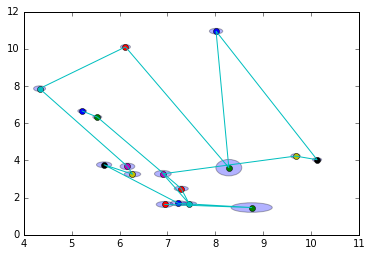

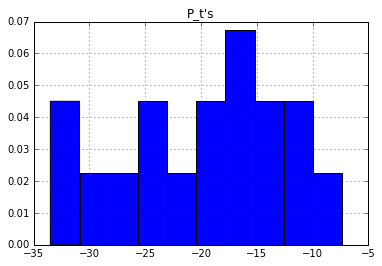

x resolution: 0.32	 y resolution:0.3230635588330485
mean transmisison power: -19.701984591515842


In [214]:

df = pd.read_csv(fname)
packets = df.groupby(['typeNr', 'subTypeNr', 'seqNr'])
triangulate_packets(packets)

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


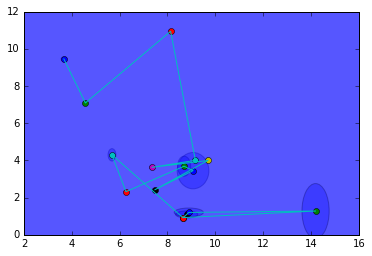

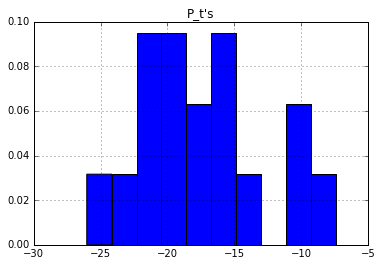

x resolution: 635063.17	 y resolution:61250.354085151324
mean transmisison power: -17.372792144065034


In [215]:
df = pd.read_csv(fname)

df['delta_time'] = df['measurementTimestamp'].diff().fillna(0)
df['time_label'] = np.nan
time_labels = []
current_label = 0
for row in df.iterrows():
    data = row[1]
    if not current_label:
        current_label = 1
    else:
        if data['delta_time'] > 20:
            current_label += 1
    time_labels.append(current_label)
df['time_label'] = pd.Series(time_labels)        
packets = df.groupby(['time_label'])
triangulate_packets(packets)

In [98]:
a = np.array([1,2,3,4])
b = np.array([1,2,3,4])
print(sum(a*b)**2)
print(sum(a**2 * b**2))

900
354
